# setup

In [ ]:
import os, re, json, glob, math, sys, random
from pathlib import Path
from typing import Dict, Iterable, Optional, Sequence, Tuple, Set
from collections import defaultdict, Counter, deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, ScalarFormatter

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# ----------------------------
# Project root (repo)
# ----------------------------
#PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/OTU-TAXA-FOUNDATION").resolve()
PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation")
SRC_DIR = PROJ_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# ----------------------------
# Local package imports (src/otu_taxa)
# ----------------------------
from otu_taxa.dataloaders_unk_balanced import (
    OTUTaxaDataset,
    MaskingConfig,
    make_tax_only_mask_collator,
)

# keep them. Otherwise we can remove later.
from otu_taxa.helpers_taxa_prediction import (
    load_vocab_json,
    norm_id,
    parse_tax_to_cols,
    is_unknown,
    evaluate_and_plot_predictions,
)

# UNK-aware metrics / decoding helpers
from otu_taxa.joint_hier_loss_metrics_unk import (
    hierarchical_predict_full_path,
    make_factorized_tax_loss_fn_fast_masked_with_unk,
    get_tax_path_for_label,
    deepest_taxonomy_accuracy_f1,   # often useful in testing
)

# UNK-aware model
from otu_taxa.otu_taxa_transformer_unk import (
    ModelConfig,
    OTUTaxaTransformerEmbedTaxTreeUnkTaxa,
)
from otu_taxa.helpers_pretraining_model import IGNORE_INDEX, set_seed


# load model 

In [ ]:
# ---------------------------
# Run paths 
# ---------------------------
run_name = "pretrain_hier_joint_unk_taxa"
RUN_DIR   = os.path.join(PROJ_ROOT, "runs_microbeatlas", run_name)
META_PATH = os.path.join(RUN_DIR, "meta.json")
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")

with open(META_PATH, "r") as f:
    meta = json.load(f)

# ---------------------------
# External dataset location 
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = meta.get("dataset_folder_name", "dataset_full_top999")  # p

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

SAMPLES_JSONL = os.path.join(dataset_dir, "samples.jsonl")
TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")

assert os.path.isfile(SAMPLES_JSONL), f"Missing samples.jsonl: {SAMPLES_JSONL}"
assert os.path.isdir(TREE_DIR), f"Missing tree_artifacts dir: {TREE_DIR}"

print("[INFO] dataset_dir:", dataset_dir)

[INFO] dataset_dir: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999


In [ ]:

# ---------------------------
# Rebuild EXACT split used in training
# ---------------------------
seed   = meta.get("seed", 123)
TEST_N = meta.get("TEST_N", 20_000)
VAL_N  = meta.get("VAL_N", 20_000)

set_seed(seed)
random.seed(seed)

ds = OTUTaxaDataset(dataset_dir)
N = len(ds)
print(f"[INFO] Dataset size: N={N}")

TEST_N = min(TEST_N, N)
VAL_N  = min(VAL_N, N - TEST_N)

all_idx = list(range(N))
random.shuffle(all_idx)

test_idx  = sorted(all_idx[:TEST_N])
val_idx   = sorted(all_idx[TEST_N:TEST_N + VAL_N])
train_idx = sorted(all_idx[TEST_N + VAL_N:])

print(f"[SPLIT] Train={len(train_idx)}  Val={len(val_idx)}  Test={len(test_idx)}  (Total N={N})")

train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)


[INFO] Dataset size: N=1836250
[SPLIT] Train=1796250  Val=20000  Test=20000  (Total N=1836250)


In [ ]:
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

# ---------------------------
# Experiment & run names 
# ---------------------------
run_name = "pretrain_hier_joint_unk_taxa"
experiment_name = "runs_microbeatlas"     

RUN_DIR   = os.path.join(PROJ_ROOT, experiment_name, run_name)
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")
META_PATH = os.path.join(RUN_DIR, "meta.json")

# ---------------------------
# Full MicrobeAtlas dataset path 
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = "dataset_full_top999"

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")
UNK_VOCAB_PATH = os.path.join(TREE_DIR, "taxonomy_vocab_with_unk.json")
UNK_M_PATH     = os.path.join(TREE_DIR, "descendant_matrix_with_unk.npy")
RANK_IDX_PATH  = os.path.join(TREE_DIR, "rank_idx.npy")

# ---------------------------
# Output location for predictions 
# ---------------------------

OUT_DIR = Path(dataset_dir) / "predictions_of_taxa" / experiment_name / run_name
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_JSONL = OUT_DIR / "pred_infrequent_taxonomy.jsonl"

# ---------------------------
# 1) meta.json 
# ---------------------------
with open(META_PATH, "r") as f:
    meta = json.load(f)

mc = meta.get("model_cfg")
if mc is None:
    raise KeyError("meta.json must contain 'model_cfg'.")

required_mc = ["d_model", "n_layers", "n_heads", "d_ff", "dropout", "activation"]
missing = [k for k in required_mc if k not in mc]
if missing:
    raise KeyError(f"meta['model_cfg'] missing required keys: {missing}")

# ---------------------------
# 2) dataset sizes 
# ---------------------------
ds = OTUTaxaDataset(dataset_dir)
O_ds = ds.O
T_real_ds = ds.T

ds_meta = meta.get("dataset", {})
if not ds_meta:
    raise KeyError("meta.json must contain 'dataset' with O/T info.")

mO     = ds_meta.get("O")
T_real = ds_meta.get("T_real")
T_base = ds_meta.get("T_base")

if mO is None or T_real is None or T_base is None:
    raise KeyError("meta['dataset'] must contain 'O', 'T_real', 'T_base'.")

if mO != O_ds:
    raise ValueError(f"Dataset O mismatch: meta O={mO}, dataset O={O_ds}")

if T_real != T_real_ds:
    raise ValueError(f"Dataset T_real mismatch: meta T_real={T_real}, dataset T={T_real_ds}")

# specials (exact same convention as training)
pad_otu_id  = O_ds
mask_otu_id = O_ds + 1

pad_tax_id  = T_base
mask_tax_id = T_base + 1

n_otus = O_ds + 2
n_taxa = T_base + 2

# ---------------------------
# 3) Load UNK tree artifacts required for hierarchical loss/decoding
# ---------------------------
with open(UNK_VOCAB_PATH, "r") as f:
    tax_vocab_unk = json.load(f)
if len(tax_vocab_unk) != T_base:
    raise ValueError(f"UNK vocab length mismatch: len(vocab_unk)={len(tax_vocab_unk)} vs T_base={T_base}")



M_np = np.load(UNK_M_PATH)  # [T_base, T_base]
if M_np.shape != (T_base, T_base):
    raise ValueError(f"Descendant matrix shape mismatch: {M_np.shape} vs expected {(T_base, T_base)}")

rank_idx = np.load(RANK_IDX_PATH)  # [T_base]
if rank_idx.shape[0] != T_base:
    raise ValueError(f"rank_idx length mismatch: {rank_idx.shape} vs T_base={T_base}")

M_tensor = torch.from_numpy(M_np).to(DEVICE)
rank_idx_t = torch.from_numpy(rank_idx).to(DEVICE)

# ---------------------------
# 4) Build loss fn 
# ---------------------------
hier_tax_loss_fn = make_factorized_tax_loss_fn_fast_masked_with_unk(
    M_tensor=M_tensor,
    rank_idx=rank_idx_t,
    tax_vocab=tax_vocab_unk,
    T_base=T_base,
)

# ---------------------------
# 5) Instantiate model exactly 
# ---------------------------
cfg = ModelConfig(**mc)

model = OTUTaxaTransformerEmbedTaxTreeUnkTaxa(
    n_otus=n_otus,
    n_taxa=n_taxa,
    pad_otu_id=pad_otu_id,
    pad_tax_id=pad_tax_id,
    config=cfg,
    tax_loss_fn=hier_tax_loss_fn,   # IMPORTANT for parity with training
)

raw = torch.load(CKPT_PATH, map_location="cpu")
if not isinstance(raw, dict):
    raise TypeError("Checkpoint must be a dict-like object.")

if "model" in raw and isinstance(raw["model"], dict):
    sd = raw["model"]
elif "state_dict" in raw and isinstance(raw["state_dict"], dict):
    sd = raw["state_dict"]
else:
    raise KeyError("Checkpoint must contain either 'model' or 'state_dict'.")

def strip_prefix_if_all(state_dict, prefix: str):
    keys = list(state_dict.keys())
    if keys and all(k.startswith(prefix) for k in keys):
        return {k[len(prefix):]: v for k, v in state_dict.items()}
    return state_dict

sd = strip_prefix_if_all(sd, "model.")
sd = strip_prefix_if_all(sd, "module.")

model.load_state_dict(sd, strict=True)
model.to(DEVICE).eval()

print("[OK] strict load succeeded; model on", DEVICE)
print(f"[INFO] dataset_dir={dataset_dir}")
print(f"[INFO] O={O_ds}, T_real={T_real}, T_base={T_base}, n_taxa={n_taxa}")
print(f"[INFO] OUT_JSONL={OUT_JSONL}")


UNK ids per rank: [6928, 6929, 6930, 6931, 6932, 6933, 6934]


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[OK] strict load succeeded; model on cuda:1
[INFO] dataset_dir=/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999
[INFO] O=62200, T_real=6929, T_base=6935, n_taxa=6937
[INFO] OUT_JSONL=/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/predictions_of_taxa/runs_microbeatlas/pretrain_hier_joint_unk_taxa/pred_infrequent_taxonomy.jsonl


In [ ]:

if isinstance(tax_vocab_unk, list):
    tax_id2name = {i: name for i, name in enumerate(tax_vocab_unk)}

elif isinstance(tax_vocab_unk, dict):
    # ensure integer keys
    tax_id2name = {int(k): v for k, v in tax_vocab_unk.items()}

else:
    raise TypeError(
        f"Unsupported taxonomy vocab type: {type(tax_vocab_unk)}"
    )

# strict sanity check
if len(tax_id2name) != T_base:
    raise ValueError(
        f"tax_id2name size mismatch: "
        f"len={len(tax_id2name)} vs T_base={T_base}"
    )

print(f"[INFO] tax_id2name created (size={len(tax_id2name)})")
print(f"[INFO] preview taxonomy names: {[tax_id2name[i] for i in range(min(5, T_base))]}")

[INFO] tax_id2name created (size=6935)
[INFO] preview taxonomy names: ['c:028H05-P-BN-P5', 'c:055B07-P-DI-P58', 'c:113B434', 'c:AB64A-17', 'c:AEGEAN-245']


# choosing infrequent OTUs

In [ ]:
# ---------------------------------------------------------
# 0) Reproducibility for the OTU selection step
# ---------------------------------------------------------
seed = meta.get("seed", 123)
random.seed(seed)

# ---------------------------------------------------------
# 1) OTU vocab mappings 
# ---------------------------------------------------------


otu_vocab_candidates = [
    os.path.join(dataset_dir, "otu_vocab.json"),
    os.path.join(TREE_DIR, "otu_vocab.json"),
]
otu_vocab_path = next((p for p in otu_vocab_candidates if os.path.isfile(p)), None)

otu_id2name = None
otu_name2id = None
if otu_vocab_path is not None:
    with open(otu_vocab_path, "r") as f:
        otu_vocab = json.load(f)
    # accept either {id: name} or list-of-names
    if isinstance(otu_vocab, dict):
        otu_id2name = {int(k): v for k, v in otu_vocab.items()}
        otu_name2id = {v: k for k, v in otu_id2name.items()}
    elif isinstance(otu_vocab, list):
        otu_id2name = {i: n for i, n in enumerate(otu_vocab)}
        otu_name2id = {n: i for i, n in otu_id2name.items()}
    print(f"[INFO] Loaded OTU vocab: {otu_vocab_path}  (size={len(otu_id2name)})")
else:
    print("[WARN] OTU vocab json not found; proceeding without names (IDs only).")

# ---------------------------------------------------------
# 2) dataset sizes 
# ---------------------------------------------------------
O_eval, T_real_eval = ds.O, ds.T
if O_eval != O_ds:
    raise ValueError(f"OTU mismatch: model block O={O_ds}, dataset O={O_eval}")
if T_real_eval != T_real:
    raise ValueError(f"T_real mismatch: model meta T_real={T_real}, dataset T={T_real_eval}")

print(f"[INFO] Eval setup: O={O_eval}, T_real={T_real_eval}, T_base={T_base}")


# ---------------------------------------------------------
# 3) Count OTU frequencies in TRAIN and TEST (by sample presence)
#     train_counts[o] = number of train samples containing OTU o at least once
#     test_counts[o]  = number of test  samples containing OTU o at least once
# ---------------------------------------------------------
def _extract_otus(rec, otu_key="otus"):
    if isinstance(rec, dict):
        otus = rec.get(otu_key, None)
        if otus is None:
            raise KeyError(f"Record missing key '{otu_key}'. Keys={list(rec.keys())}")
        return otus
    return rec[0]

def count_otu_sample_frequency(subset_ds, O_ds: int, otu_key="otus"):
    counts = Counter()
    for i in range(len(subset_ds)):
        rec = subset_ds[i]
        otus = _extract_otus(rec, otu_key=otu_key)

        if torch.is_tensor(otus):
            otus = otus.detach().cpu().view(-1).numpy()
        else:
            otus = np.asarray(otus).reshape(-1)
        # keep only real OTUs (exclude PAD/MASK): [0, O_ds-1]
        otus = otus[(otus >= 0) & (otus < O_ds)]
        if otus.size == 0:
            continue

        for o in np.unique(otus):
            counts[int(o)] += 1

    return counts

print("[INFO] Counting OTU sample-frequency in train/test subsets...")
train_counts = count_otu_sample_frequency(train_ds, O_ds=O_ds, otu_key="otus")
test_counts  = count_otu_sample_frequency(test_ds,  O_ds=O_ds, otu_key="otus")

print(f"[INFO] Unique OTUs in train: {len(train_counts)}")
print(f"[INFO] Unique OTUs in test : {len(test_counts)}")

# ---------------------------------------------------------
# 4) Choose TAIL OTUs: infrequent in TRAIN, present in TEST
# ---------------------------------------------------------
N_TRAIN_MAX      = 50   # OTU appears in <= N_TRAIN_MAX training samples
MIN_TEST_SAMPLES = 1    # OTU must appear in >= MIN_TEST_SAMPLES test samples
K_MASK_OTUS      = 100  # cap selection size (set None to use all)

seed = meta.get("seed", 123)
random.seed(seed)

tail_train_otus = {o for o, c in train_counts.items() if c <= N_TRAIN_MAX}
tail_test_otus  = sorted([o for o in tail_train_otus if test_counts.get(o, 0) >= MIN_TEST_SAMPLES])

if len(tail_test_otus) == 0:
    raise ValueError(
        f"No tail OTUs found with train<= {N_TRAIN_MAX} and test>= {MIN_TEST_SAMPLES}. "
        f"Increase N_TRAIN_MAX (e.g., 50/100) or decrease MIN_TEST_SAMPLES."
    )

if K_MASK_OTUS is None:
    mask_otu_ids = tail_test_otus
else:
    if len(tail_test_otus) < K_MASK_OTUS:
        print(
            f"[WARN] Requested K_MASK_OTUS={K_MASK_OTUS}, but only "
            f"{len(tail_test_otus)} tail OTUs available "
            f"(train<= {N_TRAIN_MAX}, test>= {MIN_TEST_SAMPLES}). "
            f"Using all available tail OTUs."
        )
        mask_otu_ids = tail_test_otus
    else:
        mask_otu_ids = sorted(random.sample(tail_test_otus, k=K_MASK_OTUS))


# Downstream compatibility:
random_otu_ids = set(map(int, mask_otu_ids))

print(
    f"[TAIL] Selected {len(mask_otu_ids)} OTUs with train_samples<= {N_TRAIN_MAX} "
    f"and test_samples>= {MIN_TEST_SAMPLES} (seed={seed})."
)
print(f"[TAIL] preview: {mask_otu_ids[:20]}")

tr = np.array([train_counts[o] for o in random_otu_ids], dtype=int)
te = np.array([test_counts.get(o, 0) for o in random_otu_ids], dtype=int)
print(f"[TAIL] train sample-counts: min/median/max = {tr.min()}/{int(np.median(tr))}/{tr.max()}")
print(f"[TAIL] test  sample-counts: min/median/max = {te.min()}/{int(np.median(te))}/{te.max()}")



[INFO] Loaded OTU vocab: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/otu_vocab.json  (size=62200)
[INFO] Eval setup: O=62200, T_real=6929, T_base=6935
[INFO] Counting OTU sample-frequency in train/test subsets...
[INFO] Unique OTUs in train: 62200
[INFO] Unique OTUs in test : 59446
[TAIL] Selected 100 OTUs with train_samples<= 50 and test_samples>= 1 (seed=123).
[TAIL] preview: [4024, 4133, 10961, 13597, 14203, 16039, 17595, 19892, 20236, 23039, 23242, 25399, 27041, 27204, 28534, 28670, 30091, 30903, 31613, 34180]
[TAIL] train sample-counts: min/median/max = 11/36/50
[TAIL] test  sample-counts: min/median/max = 1/1/3


In [ ]:
# 1) Descendant matrix with UNKs
if not os.path.isfile(UNK_M_PATH):
    raise FileNotFoundError(f"Missing UNK descendant matrix: {UNK_M_PATH}")

M_np = np.load(UNK_M_PATH)  # expected shape [T_base, T_base]
if M_np.shape != (T_base, T_base):
    raise ValueError(
        f"descendant_matrix_with_unk shape mismatch: "
        f"expected ({T_base}, {T_base}), got {M_np.shape}"
    )

M_tensor = torch.from_numpy(M_np)  #

# 2) rank_idx (global id -> rank id 0..6), 
if not os.path.isfile(RANK_IDX_PATH):
    raise FileNotFoundError(f"Missing rank_idx.npy: {RANK_IDX_PATH}")

rank_idx_np = np.load(RANK_IDX_PATH)  # expected shape [T_base]
if rank_idx_np.shape[0] != T_base:
    raise ValueError(
        f"rank_idx length mismatch: expected ({T_base},), got {rank_idx_np.shape}"
    )

# 
valid = set([-1, 0, 1, 2, 3, 4, 5, 6])
bad = sorted(set(int(x) for x in np.unique(rank_idx_np)) - valid)
if bad:
    raise ValueError(f"rank_idx contains invalid values: {bad}")

rank_idx = torch.from_numpy(rank_idx_np.astype(np.int64))  # CPU tensor, long

# 3) move once to DEVICE for inference
M_dev = M_tensor.to(DEVICE)
rank_idx_dev = rank_idx.to(DEVICE)

print(
    f"[INFO] descendant_matrix_with_unk loaded from: {UNK_M_PATH}, "
    f"shape={M_np.shape}"
)
print(
    f"[INFO] rank_idx loaded from: {RANK_IDX_PATH}, "
    f"shape={rank_idx_np.shape}, unique={sorted(set(rank_idx_np.tolist()))}"
)

[INFO] descendant_matrix_with_unk loaded from: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/tree_artifacts/descendant_matrix_with_unk.npy, shape=(6935, 6935)
[INFO] rank_idx loaded from: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/tree_artifacts/rank_idx.npy, shape=(6935,), unique=[0, 1, 2, 3, 4, 5, 6]


In [ ]:
# -------------------------
# Output
# -------------------------
PRED_DIR = Path(RUN_DIR) / "predictions"
PRED_DIR.mkdir(parents=True, exist_ok=True)

# Expect N_TRAIN_MAX to be defined by the tail-selection cell
if "N_TRAIN_MAX" not in globals():
    raise NameError("N_TRAIN_MAX not found. It must be defined in the tail-OTU selection cell.")

OUT_JSONL_TAIL = (
    PRED_DIR
    / f"pred_infrequent_taxonomy_trainLE{N_TRAIN_MAX}_per_rank.jsonl"
)


if OUT_JSONL_TAIL.exists():
    OUT_JSONL_TAIL.unlink()

print(f"[INFO] Writing TAIL-OTU predictions to: {OUT_JSONL_TAIL}")

RANK_LETTERS = ['k', 'p', 'c', 'o', 'f', 'g', 's']

# ---------------------------------------------------------
# We assume Cell 5 already created the tail set:
#   - random_otu_ids : set[int] 
# ---------------------------------------------------------
if "random_otu_ids" in globals() and random_otu_ids is not None:
    random_otu_ids = set(map(int, random_otu_ids))
elif "mask_otu_ids" in globals() and mask_otu_ids is not None:
    random_otu_ids = set(map(int, mask_otu_ids))
else:
    raise NameError(
        "Tail OTU set not found. Expected `random_otu_ids` (set) or `mask_otu_ids` (list) "
        "to be defined by the previous cell."
    )

print(f"[TAIL] using {len(random_otu_ids)} tail OTUs "
      f"(preview: {sorted(list(random_otu_ids))[:15]})")

# -------------------------
# KEEP existing collator 
# -------------------------
max_len = meta.get("max_len", 500)  # 
collate = make_tax_only_mask_collator(ds, random_otu_ids, T_base=T_base, max_len=500)

# -------------------------
# Batch iterator over test_ds only
# -------------------------
def batch_iter_only_affected_subset(subset, batch_size: int, affected_ids: set):
    batch = []
    matched = 0

    for i in range(len(subset)):
        rec = subset[i]

        otus = rec.get("otus", [])
        if torch.is_tensor(otus):
            otus = otus.view(-1).tolist()

        if set(map(int, otus)) & affected_ids:
            matched += 1
            batch.append(rec)
            if len(batch) == batch_size:
                yield collate(batch)
                batch.clear()

    if batch:
        yield collate(batch)

    print(f"[INFO] TEST filtering: subset size={len(subset)} | matched with ≥1 target OTU: {matched}")

# -------------------------
# Helpers for name mapping 
# -------------------------
def _tax_name(tid: int):
    if "tax_id2name" in globals() and tax_id2name is not None:
        if isinstance(tax_id2name, dict):
            return tax_id2name.get(int(tid), f"<id:{int(tid)}>")
        if isinstance(tax_id2name, list) and 0 <= tid < len(tax_id2name):
            return tax_id2name[tid]
    if "tax_vocab_unk" in globals() and tax_vocab_unk is not None:
        if isinstance(tax_vocab_unk, dict):
            return tax_vocab_unk.get(str(int(tid)), tax_vocab_unk.get(int(tid), f"<id:{int(tid)}>"))
        if isinstance(tax_vocab_unk, list) and 0 <= tid < len(tax_vocab_unk):
            return tax_vocab_unk[tid]
    return f"<id:{int(tid)}>"

def _otu_name(oid: int):
    if "otu_id2name" in globals() and otu_id2name is not None:
        return otu_id2name.get(int(oid), f"<otu:{int(oid)}>")
    return f"<otu:{int(oid)}>"

# -------------------------
# Prediction loop
# -------------------------
BATCH_SIZE = 4
total_samples = 0
total_masked_positions = 0

model.eval()
with torch.no_grad():
    with open(OUT_JSONL_TAIL, "w") as fjsonl:
        for batch in batch_iter_only_affected_subset(
            test_ds, BATCH_SIZE, random_otu_ids
        ):
            input_otus = batch["input_otus"].to(DEVICE)
            input_taxa = batch["input_taxa"].to(DEVICE)
            attn_mask  = batch["attention_mask"].to(DEVICE)

            out = model(
                input_otus=input_otus,
                input_taxa=input_taxa,
                attention_mask=attn_mask,
            )

            logits_tax = None
            for k in ("logits_tax", "tax_logits", "logits_taxa"):
                if isinstance(out, dict) and k in out:
                    logits_tax = out[k]
                    break
            if logits_tax is None:
                raise KeyError("Model forward output does not contain taxonomy logits.")

            # block PAD_TAX and MASK_TAX
            if pad_tax_id < logits_tax.size(-1):
                logits_tax[:, :, pad_tax_id] = float("-inf")
            if mask_tax_id < logits_tax.size(-1):
                logits_tax[:, :, mask_tax_id] = float("-inf")

            for bi, sid in enumerate(batch["sample_ids"]):
                pos_list = batch["masked_positions"][bi]
                if not pos_list:
                    continue
                total_samples += 1

                true_seq = batch["true_taxa"][bi]

                for pos in pos_list:
                    logits_vec  = logits_tax[bi, pos]    # [T_ext]
                    logits_base = logits_vec[:T_base]    # [T_base]

                    path_pred = hierarchical_predict_full_path(
                        logits_vec=logits_base,
                        M_tensor=M_dev,
                        rank_idx=rank_idx_dev,
                        R=7,
                    )

                    pred_by_rank = {}
                    for r, ch in enumerate(RANK_LETTERS):
                        pid = path_pred.get(r, None)
                        if pid is None:
                            continue
                        pred_by_rank[ch] = {
                            "tax_id": int(pid),
                            "tax_name": _tax_name(int(pid)),
                        }

                    true_val = true_seq[pos]
                    true_tid = int(true_val.item() if torch.is_tensor(true_val) else true_val)

                    otu_id = int(batch["input_otus"][bi, pos].item())

                    if 0 <= true_tid < T_base:
                        r_true = int(rank_idx_dev[true_tid].item())
                    else:
                        r_true = -1

                    if 0 <= r_true < len(RANK_LETTERS):
                        ch_true = RANK_LETTERS[r_true]
                        pid_deep = path_pred.get(r_true, None)
                        pred_flat = {
                            "tax_id": int(pid_deep) if pid_deep is not None else None,
                            "tax_name": _tax_name(int(pid_deep)) if pid_deep is not None else None,
                            "rank": ch_true,
                        }
                    else:
                        pred_flat = {"tax_id": None, "tax_name": None, "rank": None}

                    rec = {
                        "sample_id": sid,
                        "position": int(pos),
                        "otu_id": int(otu_id),
                        "otu_name": _otu_name(int(otu_id)),
                        "true_tax_id": int(true_tid),
                        "true_tax_name": _tax_name(int(true_tid)),
                        "pred_flat": pred_flat,
                        "pred_by_rank": pred_by_rank,
                    }

                    fjsonl.write(json.dumps(rec) + "\n")
                    total_masked_positions += 1

print(f"[DONE] wrote TAIL predictions to: {OUT_JSONL_TAIL}")
print(f"[INFO] samples with ≥1 masked tail OTU: {total_samples}")
print(f"[INFO] total masked positions (tail OTUs): {total_masked_positions}")


[INFO] Writing TAIL-OTU predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas/pretrain_hier_joint_unk_taxa/predictions/pred_infrequent_taxonomy_trainLE50_per_rank.jsonl
[TAIL] using 100 tail OTUs (preview: [4024, 4133, 10961, 13597, 14203, 16039, 17595, 19892, 20236, 23039, 23242, 25399, 27041, 27204, 28534])
[INFO] TEST filtering: subset size=20000 | matched with ≥1 target OTU: 97
[DONE] wrote TAIL predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas/pretrain_hier_joint_unk_taxa/predictions/pred_infrequent_taxonomy_trainLE50_per_rank.jsonl
[INFO] samples with ≥1 masked tail OTU: 93
[INFO] total masked positions (tail OTUs): 111


# predictions print

In [ ]:
from otu_taxa.metrics_figures import (
    evaluate_and_plot_predictions_multilabel, 
    plot_per_level_accuracy_hierarchical_from_arrays, 
    load_predictions_with_pred_gold, 
    strict_error_origin_matrix_and_rankACC, 
    plot_strict_matrix_with_rankACC, 
    plot_error_origin_matrix_rowpct_colored,
    compute_global_rankACC, 
    build_accuracy_vs_rankACC_table
)

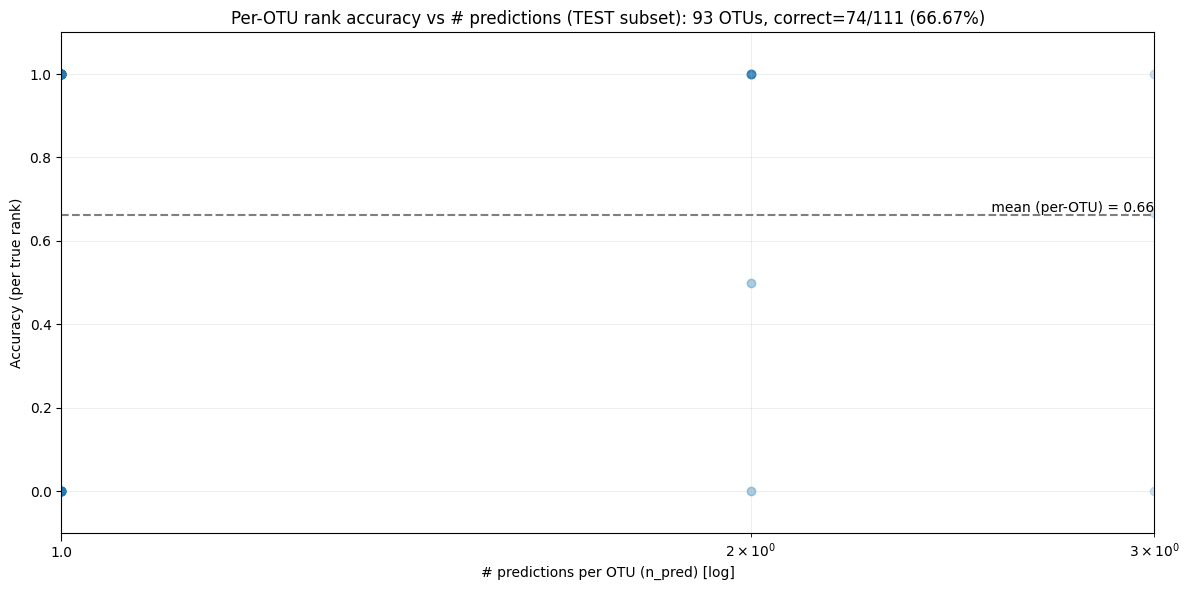

[INFO] multilabel eval: 93 unique samples, 111 predictions, 93 OTUs | correct=74/111 (66.67%)


In [20]:
df_raw, df_otu, summary, fig = evaluate_and_plot_predictions_multilabel(
    jsonl_path=OUT_JSONL_TAIL,
    title_prefix="Per-OTU rank accuracy vs # predictions (TEST subset)"
)


In [ ]:
from otu_taxa.dataloaders_unk_balanced import build_tax2ancestor_at_rank, build_tax2rank_from_vocab 

RANKS = ("k","p","c","o","f","g","s")

# M_np must be the descendant closure used by the hierarchical loss: shape [T_base, T_base]
# tax_vocab_list must be length T_base (UNK-extended)
tax2rank = build_tax2rank_from_vocab(tax_vocab_unk)

ancestor_at_rank = {
    r: build_tax2ancestor_at_rank(
        M_np=M_np,                    # np.ndarray [T_base, T_base]
        tax_vocab_list=tax_vocab_unk,  # list[str] length T_base
        target_rank=r,
        missing_value=-1,
    )
    for r in RANKS
}

# quick sanity
for r in RANKS:
    assert len(ancestor_at_rank[r]) == M_np.shape[0]
print("[OK] built ancestor arrays for ranks:", RANKS)


[OK] built ancestor arrays for ranks: ('k', 'p', 'c', 'o', 'f', 'g', 's')


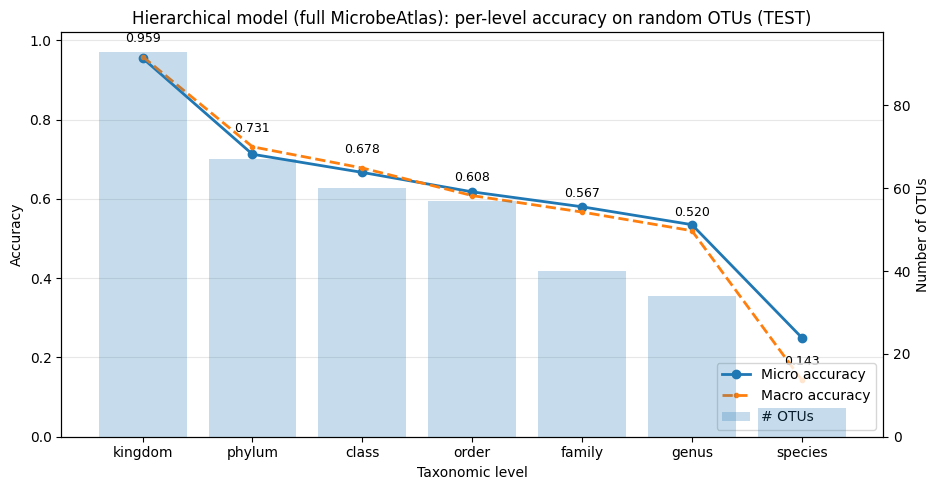

[INFO] overall micro (avg over levels) = 0.617, mean macro (avg over levels) = 0.601


,level,n_rows_used,n_otus_used,micro_acc,macro_acc
0,kingdom,111,93,0.9550,0.9588
1,phylum,80,67,0.7125,0.7313
2,class,72,60,0.6667,0.6778
3,order,68,57,0.6176,0.6082
4,family,50,40,0.5800,0.5667
5,genus,43,34,0.5349,0.5196
6,species,8,7,0.2500,0.1429


In [ ]:
JSONL_PER_RANK = OUT_JSONL_TAIL  # 

df_all, per_level_summary, overall, fig = plot_per_level_accuracy_hierarchical_from_arrays(
    jsonl_path=JSONL_PER_RANK,
    ancestor_at_rank=ancestor_at_rank,
    test_ids=None,  
    ranks=("k","p","c","o","f","g","s"),
    title="Hierarchical model (full MicrobeAtlas): per-level accuracy on random OTUs (TEST)"
)

display(per_level_summary)


In [ ]:
RANKS = ("k","p","c","o","f","g","s")

# ------------------------------------------------------------
# 0) Build gold ancestor arrays 
# ------------------------------------------------------------
def build_ancestor_arrays_all_ranks(M_np, tax_vocab_unk, ranks=RANKS, missing_value=-1):
    """
    Returns dict rank -> dense list length T_base:
      ancestor_at_rank[r][t] = ancestor tax_id at rank r, else -1.
    """
    ancestor_at_rank = {}
    for r in ranks:
        ancestor_at_rank[r] = build_tax2ancestor_at_rank(
            M_np=M_np,
            tax_vocab_list=tax_vocab_unk,
            target_rank=r,
            missing_value=missing_value,
        )
    return ancestor_at_rank

Global rankACC: 0.7681


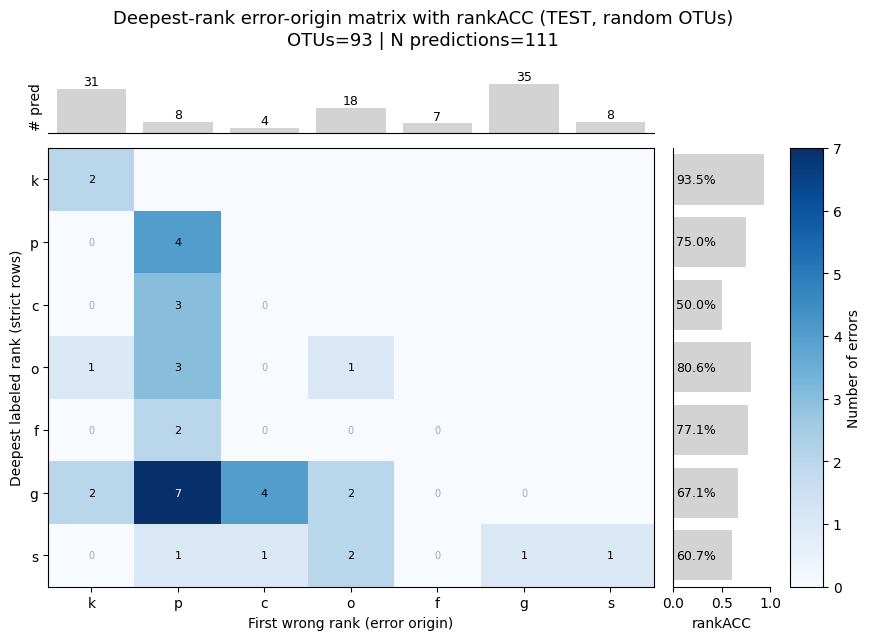

In [ ]:
ancestor_at_rank = build_ancestor_arrays_all_ranks(
    M_np=M_np,                 # [T_base, T_base] np.ndarray
    tax_vocab_unk=tax_vocab_unk,
    ranks=RANKS,
    missing_value=-1,
)
df = load_predictions_with_pred_gold(
    jsonl_path=JSONL_PER_RANK,   # your JSONL path
    ancestor_at_rank=ancestor_at_rank,
    ranks=RANKS,
)
counts_strict, meta_strict = strict_error_origin_matrix_and_rankACC(df, ranks=RANKS)

# # 4) Plot
# plot_strict_matrix_with_rankACC(
#     counts_strict,
#     meta_strict,
#     title="Deepest-rank error-origin matrix with rankACC (TEST, random OTUs)",
#     ranks=RANKS,
#     df=df,
#     otu_col="otu_id",   # or "otu_name" if your JSONL doesn’t have otu_id
#     show_zeros_lower=True,
# )

# 5) Global rankACC
global_rankACC, df_with_rankacc = compute_global_rankACC(df, ranks=RANKS)
print(f"Global rankACC: {global_rankACC:.4f}")


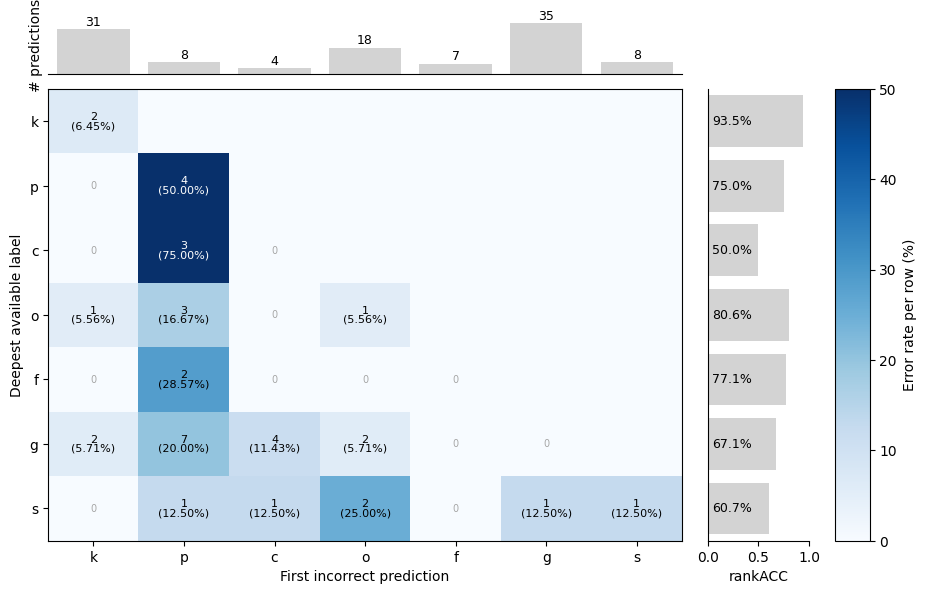

In [ ]:
fig, axes = plot_error_origin_matrix_rowpct_colored(
    counts_strict,
    meta_strict,
    title= "",#"Deepest-rank error origin (TEST)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",
    show_zeros_lower=True,
    show_percent_text=True,  
    vmax_pct=50.0,            
    vmin_pct=0.0,
)


In [ ]:


acc_table = build_accuracy_vs_rankACC_table(df, ranks=RANKS)
display(
    acc_table
    .assign(
        standard_accuracy=lambda x: x["standard_accuracy"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
        rankACC=lambda x: x["rankACC"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
    )
)


,standard_accuracy,rankACC,n_rows
k,0.9355,0.9355,31
p,0.5000,0.7500,8
c,0.2500,0.5000,4
o,0.7222,0.8056,18
f,0.7143,0.7714,7
g,0.5714,0.6714,35
s,0.2500,0.6071,8
Global,0.6667,0.7681,111
